# ARIMA দিয়ে টাইম সিরিজ পূর্বাভাস

এই নোটবুকে, আমরা দেখাবো কিভাবে:
- ARIMA টাইম সিরিজ পূর্বাভাস মডেলের জন্য টাইম সিরিজ ডেটা প্রস্তুত করতে হয়
- একটি সহজ ARIMA মডেল প্রয়োগ করে টাইম সিরিজের পরবর্তী HORIZON ধাপ (সময় *t+1* থেকে *t+HORIZON* পর্যন্ত) পূর্বাভাস করতে হয়
- মডেল মূল্যায়ন করতে হয়

এই উদাহরণের ডেটা GEFCom2014 পূর্বাভাস প্রতিযোগিতা থেকে নেওয়া হয়েছে। এটি ২০১২ থেকে ২০১৪ সালের মধ্যে ৩ বছরের ঘণ্টাভিত্তিক বিদ্যুৎ লোড এবং তাপমাত্রার মান নিয়ে গঠিত। কাজটি হলো ভবিষ্যতের বিদ্যুৎ লোডের মান পূর্বাভাস করা। এই উদাহরণে, আমরা কেবল ঐতিহাসিক লোড ডেটা ব্যবহার করে এক ধাপ আগের সময়ের পূর্বাভাস দেখাবো।

তাও হং, পিয়েরে পিনসন, শু ফ্যান, হামিদরেজা জারেইপুর, আলবার্তো ট্রোকোলি এবং রব জে. হাইন্ডম্যান, "সম্ভাব্য শক্তি পূর্বাভাস: গ্লোবাল এনার্জি ফোরকাস্টিং কম্পিটিশন ২০১৪ এবং তার পরবর্তী", ইন্টারন্যাশনাল জার্নাল অফ ফোরকাস্টিং, ভলিউম ৩২, নং ৩, পৃষ্ঠা ৮৯৬-৯১৩, জুলাই-সেপ্টেম্বর, ২০১৬।


## নির্ভরশীলতা ইনস্টল করুন  
কিছু প্রয়োজনীয় নির্ভরশীলতা ইনস্টল করে শুরু করুন। এই লাইব্রেরিগুলি এবং তাদের সংশ্লিষ্ট সংস্করণগুলি সমাধানের জন্য কার্যকর বলে পরিচিত:  

* `statsmodels == 0.12.2`  
* `matplotlib == 3.4.2`  
* `scikit-learn == 0.24.2`  


In [16]:
!pip install statsmodels

/bin/sh: pip: command not found


In [17]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [18]:
energy = load_data('./data')[['load']]
energy.head(10)

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
2012-01-01 05:00:00 2,453.00
2012-01-01 06:00:00 2,560.00
2012-01-01 07:00:00 2,719.00
2012-01-01 08:00:00 2,916.00
2012-01-01 09:00:00 3,105.00

সমস্ত উপলব্ধ লোড ডেটা (জানুয়ারি ২০১২ থেকে ডিসেম্বর ২০১৪) প্লট করুন


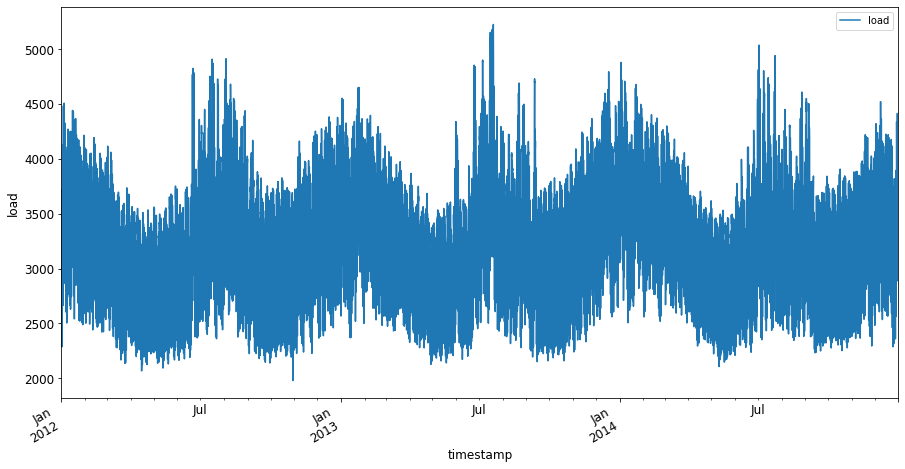

In [19]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## প্রশিক্ষণ এবং পরীক্ষার ডেটাসেট তৈরি করুন

### প্রশিক্ষণ ডেটাসেট তৈরি করা
প্রশিক্ষণ ডেটাসেট তৈরি করতে, আপনাকে প্রথমে আপনার ডেটা সংগ্রহ করতে হবে। এটি বিভিন্ন উৎস থেকে আসতে পারে, যেমন ডাটাবেস, API, বা ফাইল। নিশ্চিত করুন যে ডেটা পরিষ্কার এবং সঠিকভাবে লেবেল করা হয়েছে।

[!TIP] ডেটা সংগ্রহ করার সময়, বিভিন্ন শ্রেণির মধ্যে ভারসাম্য বজায় রাখার চেষ্টা করুন। এটি আপনার মডেলের কর্মক্ষমতা উন্নত করতে সাহায্য করবে।

### ডেটা প্রি-প্রসেসিং
ডেটা প্রি-প্রসেসিং একটি গুরুত্বপূর্ণ ধাপ। এটি অন্তর্ভুক্ত করতে পারে:
- অনুপযুক্ত বা অনুপস্থিত মান সরানো
- ডেটা স্কেলিং বা নরমালাইজেশন
- টেক্সট ডেটার ক্ষেত্রে টোকেনাইজেশন এবং স্টপওয়ার্ড সরানো

[!NOTE] প্রি-প্রসেসিং ধাপগুলি আপনার নির্দিষ্ট ডেটাসেট এবং মডেলের প্রয়োজনীয়তার উপর নির্ভর করবে।

### ডেটা বিভাজন
ডেটাকে প্রশিক্ষণ এবং পরীক্ষার সেটে বিভক্ত করুন। সাধারণত, ডেটার ৭০-৮০% প্রশিক্ষণের জন্য এবং ২০-৩০% পরীক্ষার জন্য ব্যবহার করা হয়। উদাহরণ:

```python
train_data, test_data = split_data(data, train_ratio=0.8)
```

[!WARNING] নিশ্চিত করুন যে প্রশিক্ষণ এবং পরীক্ষার সেটে ডেটা ওভারল্যাপ না হয়।

### পরীক্ষার ডেটাসেট তৈরি করা
পরীক্ষার ডেটাসেটটি মডেলের কর্মক্ষমতা মূল্যায়নের জন্য ব্যবহার করা হয়। এটি প্রশিক্ষণের সময় ব্যবহার করা উচিত নয়। নিশ্চিত করুন যে পরীক্ষার ডেটাসেট প্রশিক্ষণের ডেটাসেটের মতোই বৈচিত্র্যময়।

[!CAUTION] পরীক্ষার ডেটাসেট খুব ছোট হলে, এটি মডেলের কর্মক্ষমতা সঠিকভাবে মূল্যায়ন করতে পারে না।


In [20]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

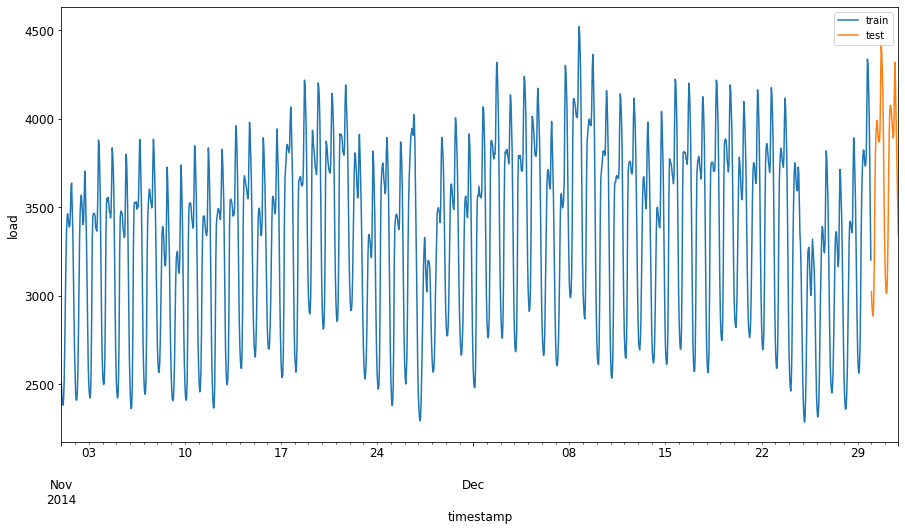

In [21]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [23]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

মূল বনাম স্কেলড ডেটা:


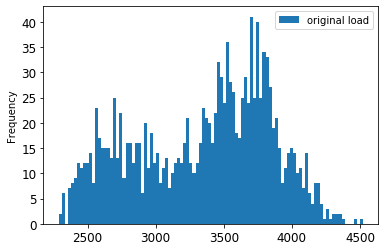

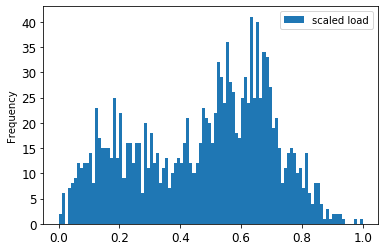

In [24]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

চলুন পরীক্ষার ডেটাও স্কেল করি


In [25]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [27]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.239
Date:                            Thu, 30 Sep 2021   AIC                          -6942.477
Time:                                    14:36:28   BIC                          -6911.050
Sample:                                11-01-2014   HQIC                         -6930.725
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.226      0.000       0.809       0.872
ar.L2         -0.5220      0.034   

## মডেল মূল্যায়ন করুন


প্রতিটি HORIZON ধাপের জন্য একটি পরীক্ষার ডেটা পয়েন্ট তৈরি করুন।


In [28]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

পরীক্ষার ডেটাতে পূর্বাভাস তৈরি করুন


In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

ভবিষ্যদ্বাণীকে প্রকৃত লোডের সাথে তুলনা করুন


In [30]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    3,008.74 3,023.00
1 2014-12-30 01:00:00  t+1    2,955.53 2,935.00
2 2014-12-30 02:00:00  t+1    2,900.17 2,899.00
3 2014-12-30 03:00:00  t+1    2,917.69 2,886.00
4 2014-12-30 04:00:00  t+1    2,946.99 2,963.00

সমস্ত পূর্বাভাসের উপর **গড় পরম শতাংশ ত্রুটি (MAPE)** গণনা করুন

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$


In [31]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5570581332313952 %


In [33]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1460048657704118 %


পরীক্ষার সেটের প্রথম সপ্তাহের জন্য পূর্বাভাস বনাম প্রকৃত মানগুলি চিত্রিত করুন


No handles with labels found to put in legend.


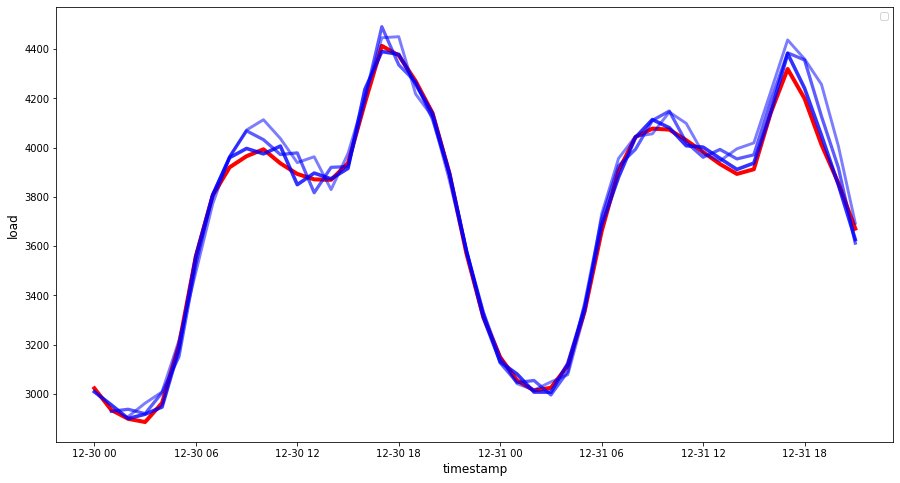

In [34]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


---

**অস্বীকৃতি**:  
এই নথিটি AI অনুবাদ পরিষেবা [Co-op Translator](https://github.com/Azure/co-op-translator) ব্যবহার করে অনুবাদ করা হয়েছে। আমরা যথাসম্ভব সঠিক অনুবাদ প্রদানের চেষ্টা করি, তবে অনুগ্রহ করে মনে রাখবেন যে স্বয়ংক্রিয় অনুবাদে ত্রুটি বা অসঙ্গতি থাকতে পারে। মূল ভাষায় থাকা নথিটিকে প্রামাণিক উৎস হিসেবে বিবেচনা করা উচিত। গুরুত্বপূর্ণ তথ্যের জন্য, পেশাদার মানব অনুবাদ সুপারিশ করা হয়। এই অনুবাদ ব্যবহারের ফলে কোনো ভুল বোঝাবুঝি বা ভুল ব্যাখ্যা হলে আমরা দায়বদ্ধ থাকব না।
